<img src="https://www.kaggle.com/static/images/site-logo.png" width=30% align='left'>

# Kaggle Competition: Titanic Dataset
<br>Link to the Competition: https://www.kaggle.com/c/titanic/overview

***
**Responsible:** Danillo Henrique F. Silva (https://github.com/dhsilva2912)
***

## Libraries:
***

In [1]:
#Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use('ggplot')
%matplotlib inline

## Step 1: Load Dataset
***

In [2]:
#Extract Train Dataset:
df_titanic = pd.read_csv('data/train.csv')

df_titanic.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,244310,13.0000,NaN,S
523,524,1,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",female,44.0,0,1,111361,57.9792,B18,C
551,552,0,2,"Sharp, Mr. Percival James R",male,27.0,0,0,244358,26.0000,NaN,S
612,613,1,3,"Murphy, Miss. Margaret Jane",female,NaN,1,0,367230,15.5000,NaN,Q
538,539,0,3,"Risien, Mr. Samuel Beard",male,NaN,0,0,364498,14.5000,NaN,S


## Step 2: Understanding the Main Figures from the Dataset
***

In [3]:
#Inspect Columns and Values from Dataset:

print('Dataset Size : {}'.format(df_titanic.shape))
print('\nDataset Features: {}'.format(df_titanic.columns))
print('\nDataset Main Info:')
print(df_titanic.info())

Dataset Size : (891, 12)

Dataset Features: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Dataset Main Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


### Step 2.1: Indetify the Main Features from the Model
***
**PassengerId:** The Unique Identifier for each Passenger onboard

**Survived:** Binary Classifier (0=No, 1=Yes), our <font color=red>**TARGET**</font>

**Pclass:** The Ticket Class (1=1st, 2=2nd, 3=3rd)

**Name:** The Passenger Name

**Sex:** The Passenger Sex (Male/Female)

**Age:** Age in Years.Age is fractional if less than 1. If estimated, is it in the form of xx.5

**SibSp:** # of parents / Children aboard the Titanic. The definition of family on this problem is: Sibling=brother,sister,stepbrother,stepsister / Spouse=husband,wife (mistresses and fiances were ignored)

**Parch:** # of parents / children aboard the Titanic. The definition of family relations are: Parent=mother,father / Child=daughter,son,stepdaughter,stepson.

**Ticket:** Ticket Number

**Fare:** Passenger fare

**Cabin:** Cabin number

**Embarked:** Port of Embarkation (C=Chebourg, Q=Queenstown, S=Southampton)

## Step 3: Exploratory Data Analysis + Feature Engineering
***

### Step 3.1: Survival
***

Class 0 (No): 61.62
Class 1 (Yes): 38.38


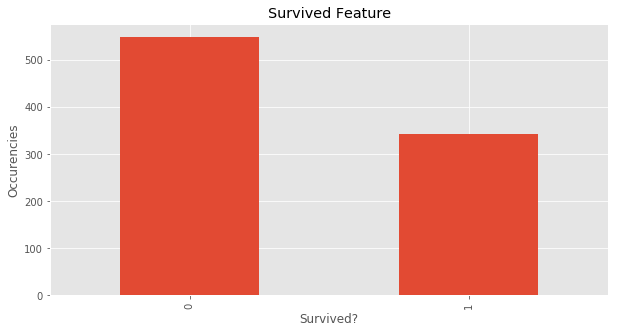

In [4]:
#Understand the Survival Rates:

df_titanic['Survived'].value_counts().plot(kind='bar',figsize=(10,5))

_= plt.title('Survived Feature')
_= plt.xlabel('Survived?')
_= plt.ylabel('Occurencies')

print('Class 0 (No): {}'.format(round(df_titanic['Survived'].value_counts()[0]/
                                      df_titanic['Survived'].value_counts().sum()*100,2)))
print('Class 1 (Yes): {}'.format(round(df_titanic['Survived'].value_counts()[1]/
                                       df_titanic['Survived'].value_counts().sum()*100,2)))

The Graph above indicates that we don't have a balanced base across the both Predictors Classes that we intend to predict.
This is a good hint that we'll take into account in order to **Stratify** our Train and Validate Samples.

### Step 3.2: Pclass
***

Class 1 (First): 24.24
Class 2 (Second): 20.65
Class 3 (Third): 55.11


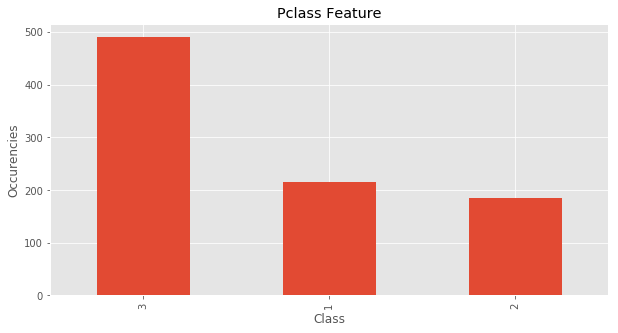

In [5]:
#Understand the Classes Relations:

df_titanic['Pclass'].value_counts().plot(kind='bar',figsize=(10,5))

_= plt.title('Pclass Feature')
_= plt.xlabel('Class')
_= plt.ylabel('Occurencies')

print('Class 1 (First): {}'.format(round(df_titanic['Pclass'].value_counts()[1]/
                                      df_titanic['Pclass'].value_counts().sum()*100,2)))
print('Class 2 (Second): {}'.format(round(df_titanic['Pclass'].value_counts()[2]/
                                       df_titanic['Pclass'].value_counts().sum()*100,2)))
print('Class 3 (Third): {}'.format(round(df_titanic['Pclass'].value_counts()[3]/
                                       df_titanic['Pclass'].value_counts().sum()*100,2)))

In order to properly use the **Pclass** Variable on our Dataset we need to Encode the Values, because the numbers represents the Classes that each Passenger have Travel. This means that this Variable is Categorical.

In [6]:
#Define Enconde Function - For All Categorical Features:

def Encode_Class(df, name):
    df = pd.concat([df, pd.get_dummies(df[name], prefix=name)], axis=1)
    df.drop(labels=name, axis=1, inplace=True)
    return df

In [7]:
#Apply Function on Dataset:

df_titanic = Encode_Class(df_titanic, 'Pclass')

df_titanic.sample(5)

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3
475,476,0,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.0000,A14,S,1,0,0
365,366,0,"Adahl, Mr. Mauritz Nils Martin",male,30.0,0,0,C 7076,7.2500,NaN,S,0,0,1
400,401,1,"Niskanen, Mr. Juha",male,39.0,0,0,STON/O 2. 3101289,7.9250,NaN,S,0,0,1
354,355,0,"Yousif, Mr. Wazli",male,NaN,0,0,2647,7.2250,NaN,C,0,0,1
867,868,0,"Roebling, Mr. Washington Augustus II",male,31.0,0,0,PC 17590,50.4958,A24,S,1,0,0


### Step 3.3: Name
***

In [8]:
#Inspect a few Name Examples:

df_titanic['Name'].sample(5)

303                Keane, Miss. Nora A
258                   Ward, Miss. Anna
869    Johnson, Master. Harold Theodor
405                 Gale, Mr. Shadrach
397            McKane, Mr. Peter David
Name: Name, dtype: object

It's possible to notice that all names follows a similar pattern:

```<Surname>, <Title>. <Name>```

In order to group this Feature we can inspect and understand how the people were grouped due their **Title**.

In [9]:
#Define Title Function:

def Get_Title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    if title_search:
        return title_search.group(1)
    return ""

In [10]:
#Apply Function and Inspect Results:

pd.crosstab(df_titanic['Name'].apply(Get_Title),df_titanic['Sex'])

Sex,female,male
Name,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


It's possible to notice that could be useful to Transform the **Title** into Categories, instead of using each Passenger Name.

But, we need to summarize the names in order to have a reasonable quantity of Variables. In order to do so, all categories that are minor than 10 Passengers are going to be grouped as **Other**.

In [11]:
#Define Name/Title transformation Function:

def Name_into_Titles(df, name):
    df['Title'] = df[name].apply(Get_Title)
    
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                       'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                       'Jonkheer', 'Dona'], 'Other')
        
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
      
    df.drop(labels=name, axis=1, inplace=True)
    
    df = Encode_Class(df, 'Title')
        
    return df

In [12]:
df_titanic = Name_into_Titles(df_titanic, 'Name')

df_titanic.sample(5)

,PassengerId,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
750,751,1,female,4.0,1,1,29103,23.0000,NaN,S,0,1,0,0,1,0,0,0
484,485,1,male,25.0,1,0,11967,91.0792,B49,C,1,0,0,0,0,1,0,0
266,267,0,male,16.0,4,1,3101295,39.6875,NaN,S,0,0,1,0,0,1,0,0
339,340,0,male,45.0,0,0,113784,35.5000,T,S,1,0,0,0,0,1,0,0
498,499,0,female,25.0,1,2,113781,151.5500,C22 C26,S,1,0,0,0,0,0,1,0


### Step 3.4: Sex
***

Male: 64.76
Female: 35.24


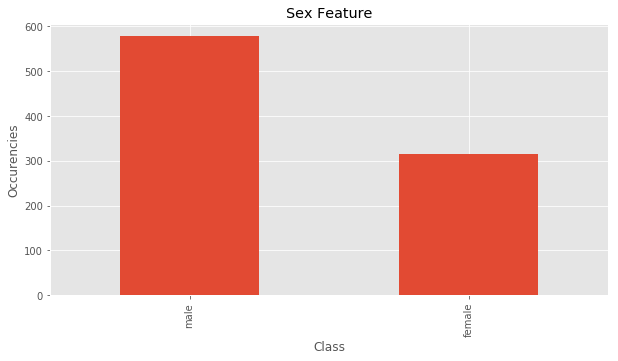

In [13]:
#Inspect Sex Feature:

df_titanic['Sex'].value_counts().plot(kind='bar',figsize=(10,5))

_= plt.title('Sex Feature')
_= plt.xlabel('Class')
_= plt.ylabel('Occurencies')

print('Male: {}'.format(round(df_titanic['Sex'].value_counts()['male']/
                                      df_titanic['Sex'].value_counts().sum()*100,2)))
print('Female: {}'.format(round(df_titanic['Sex'].value_counts()['female']/
                                       df_titanic['Sex'].value_counts().sum()*100,2)))

As we've seen before, we're going to transform This Feature into Categorical.

In [16]:
#Transform Sex Feature into Categorical:

df_titanic = Encode_Class(df_titanic,'Sex')

df_titanic.sample(5)

,PassengerId,Survived,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Sex_female,Sex_male
531,532,0,NaN,0,0,2641,7.2292,NaN,C,0,0,1,0,0,1,0,0,0,1
298,299,1,NaN,0,0,19988,30.5000,C106,S,1,0,0,0,0,1,0,0,0,1
489,490,1,9.00,1,1,C.A. 37671,15.9000,NaN,S,0,0,1,1,0,0,0,0,0,1
133,134,1,29.00,1,0,228414,26.0000,NaN,S,0,1,0,0,0,0,1,0,1,0
803,804,1,0.42,0,1,2625,8.5167,NaN,C,0,0,1,1,0,0,0,0,0,1


### Step 3.5: Age
***